# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Признаки</b>  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
  
<b>Целевой признак</b>  
Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('/datasets/autos.csv')
original_df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных много пропусков. 3 столбца необходимо трансформировать в формат даты. Кроме того, многие столбцы представлены категориальными признаками и могут быть перекодированы.

In [5]:
df.describe().round(2)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.0,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.0,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.0,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.0,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.0,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.0,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.0,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.0,99998.00


Обращают на себя внимание различные аномалии:
1) Минимальное значение столбца Price - 0, это странно и вряд ли поможет в нашей задаче  
2) Минимальное значение столбца RegistrationYear - 1000, а максимальное - 9999  
3) Минимальное значение столбца Power - 0 - это может быть объяснено тем, что человек просто не знает мощность авто.   Максимальное значение - 20000 - автомобилей с такой мощностью индустрия еще не видела.   
4) RegistrationMonth: Нулевой месяц регистрации невозможен  
5) NumberOfPictures: Фотографий в принципе нет ни у одной позиции.  

Рассмотрим данные столбцы подробнее и удалим аномалии там, где это уместно.

### Проверка на дубликаты

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

### Обработка аномальных значений

#### Price

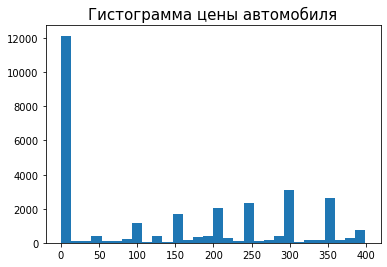

In [8]:
plt.hist(df.query('Price < 400')['Price'], bins=30)
plt.title('Гистограмма цены автомобиля', fontsize=15)
plt.show()

In [9]:
df.query('Price < 400')['Price'].value_counts(normalize=True)

0      0.358839
300    0.090976
350    0.083747
250    0.073020
200    0.066158
         ...   
108    0.000033
331    0.000033
293    0.000033
261    0.000033
47     0.000033
Name: Price, Length: 222, dtype: float64

In [10]:
df.query('Price < 400')['Price'].value_counts()

0      10772
300     2731
350     2514
250     2192
200     1986
       ...  
108        1
331        1
293        1
261        1
47         1
Name: Price, Length: 222, dtype: int64

In [11]:
len(df.query('Price == 0'))/len(original_df)*100

3.0397692800442475

3% - не очень много. Избавимся от данного значения

In [12]:
df = df.query('Price != 0').reset_index(drop=True)

#### RegistrationYear

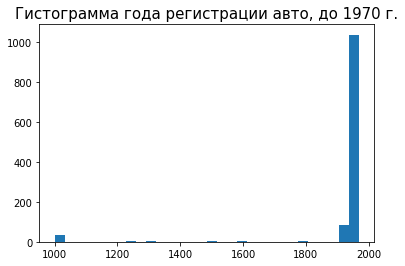

In [13]:
plt.hist(df.query('RegistrationYear < 1970')['RegistrationYear'], bins=30)
plt.title('Гистограмма года регистрации авто, до 1970 г.', fontsize=15)
plt.show()

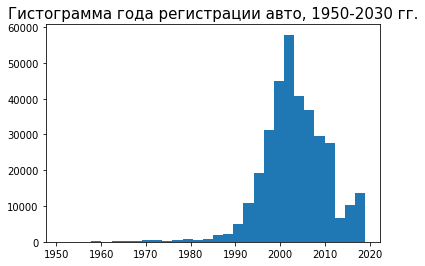

In [14]:
plt.hist(df.query('RegistrationYear > 1950 and RegistrationYear < 2030')['RegistrationYear'], bins=30)
plt.title('Гистограмма года регистрации авто, 1950-2030 гг.', fontsize=15)
plt.show()

In [15]:
(len(original_df)-len(df.query('RegistrationYear > 1950 and RegistrationYear < 2030')))/len(original_df)*100

3.120476113881293

Пожертвуем 3% данных

In [16]:
df = df.query('RegistrationYear > 1950 and RegistrationYear < 2030').reset_index(drop=True)

In [17]:
df['RegistrationYear'].value_counts(normalize=True)

2000    0.067204
1999    0.064064
2005    0.062695
2006    0.057321
2001    0.057245
          ...   
1957    0.000038
1955    0.000038
1951    0.000029
1954    0.000026
1952    0.000023
Name: RegistrationYear, Length: 69, dtype: float64

#### Power

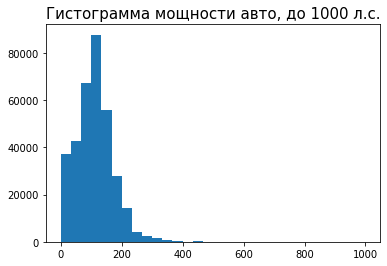

In [18]:
plt.hist(df.query('Power < 1000')['Power'], bins=30)
plt.title('Гистограмма мощности авто, до 1000 л.с.', fontsize=15)
plt.show()

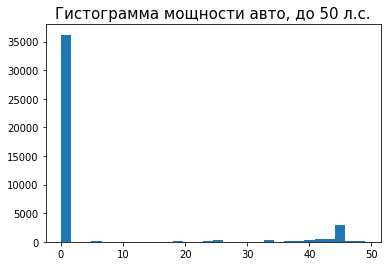

In [19]:
plt.hist(df.query('Power < 50')['Power'], bins=30)
plt.title('Гистограмма мощности авто, до 50 л.с.', fontsize=15)
plt.show()

In [20]:
len(df.query('Power == 0'))/len(original_df)*100

10.206874754845938

10% позиций в данных имеют мощность, равную 0 - слишком большой объем информации, чтобы пренебречь. Оставим, как есть.

In [21]:
len(df.query('Power > 1000'))/len(original_df)*100

0.07901368347682783

0,07% - можно пренебречь данными и избавиться от них

In [22]:
df = df.query('Power < 1000').reset_index(drop=True)

#### RegistrationMonth

In [23]:
df['RegistrationMonth'].value_counts(normalize=True)

3     0.098508
0     0.095249
6     0.089803
4     0.083579
5     0.083110
7     0.077670
10    0.074600
11    0.069201
12    0.069193
9     0.068094
1     0.065933
8     0.064485
2     0.060575
Name: RegistrationMonth, dtype: float64

Месяца 0 действительно не существует. Но пренебрегать 10% информации нельзя. Сделаем допущение, что для нас важен только год регистрации авто, поэтому избавимся от месяца, чтобы он не искажал результаты модели.

In [24]:
df = df.drop(columns=['RegistrationMonth'])

#### NumberOfPictures

In [25]:
df['NumberOfPictures'].value_counts(normalize=True)

0    1.0
Name: NumberOfPictures, dtype: float64

Фотографий действительно нигде нет. Удалим столбец как ненесущий какую-либо информацию.

In [26]:
df = df.drop(columns=['NumberOfPictures'])

### Работа с датами

С точки зрения дат для нас значимым фактором является возраст автомобиля на момент формирования анкеты.  
Для начала трансформируем столбцы в формат даты.

In [27]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y.%m.%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y.%m.%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y.%m.%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343028 entries, 0 to 343027
Data columns (total 14 columns):
DateCrawled         343028 non-null datetime64[ns]
Price               343028 non-null int64
VehicleType         309492 non-null object
RegistrationYear    343028 non-null int64
Gearbox             325854 non-null object
Power               343028 non-null int64
Model               325651 non-null object
Kilometer           343028 non-null int64
FuelType            313776 non-null object
Brand               343028 non-null object
NotRepaired         277463 non-null object
DateCreated         343028 non-null datetime64[ns]
PostalCode          343028 non-null int64
LastSeen            343028 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(6)
memory usage: 36.6+ MB


Создадим столбец, в котором будет указан возраст авто.

In [28]:
df['VehicleAge'] = pd.DatetimeIndex(df['DateCreated']).year - df['RegistrationYear']

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343028 entries, 0 to 343027
Data columns (total 15 columns):
DateCrawled         343028 non-null datetime64[ns]
Price               343028 non-null int64
VehicleType         309492 non-null object
RegistrationYear    343028 non-null int64
Gearbox             325854 non-null object
Power               343028 non-null int64
Model               325651 non-null object
Kilometer           343028 non-null int64
FuelType            313776 non-null object
Brand               343028 non-null object
NotRepaired         277463 non-null object
DateCreated         343028 non-null datetime64[ns]
PostalCode          343028 non-null int64
LastSeen            343028 non-null datetime64[ns]
VehicleAge          343028 non-null int64
dtypes: datetime64[ns](3), int64(6), object(6)
memory usage: 39.3+ MB


In [30]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,VehicleAge
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57,23
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46,12
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,15
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,8


In [31]:
df['VehicleAge'].value_counts()

16    23048
17    21974
11    21508
10    19668
15    19634
      ...  
61       13
59       13
65       10
62        9
64        8
Name: VehicleAge, Length: 69, dtype: int64

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3187: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  new_data = self.loc[res]


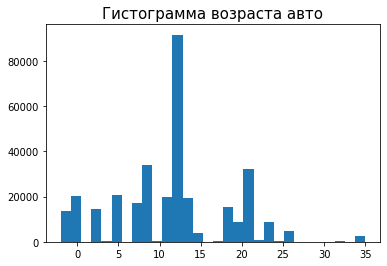

In [32]:
plt.hist(df.query('VehicleAge')['VehicleAge'], bins=30)
plt.title('Гистограмма возраста авто', fontsize=15)
plt.show()

In [33]:
df.query('VehicleAge<0')['VehicleAge'].value_counts()

-1    9880
-2    3779
-3      16
Name: VehicleAge, dtype: int64

Мы обнаружили, что некоторые авто имеют регистрацию более поздней даты, чем дата создания анкеты. Такого не может быть. Удалим данные анкеты из базы.

In [34]:
df = df.query('VehicleAge >= 0').reset_index(drop=True)

Избавимся от всех ненужных столбцов

In [35]:
df = df.drop(columns=['RegistrationYear', 'LastSeen', 'DateCrawled', 'PostalCode', 'DateCreated'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329353 entries, 0 to 329352
Data columns (total 10 columns):
Price          329353 non-null int64
VehicleType    309473 non-null object
Gearbox        313819 non-null object
Power          329353 non-null int64
Model          313803 non-null object
Kilometer      329353 non-null int64
FuelType       305272 non-null object
Brand          329353 non-null object
NotRepaired    269648 non-null object
VehicleAge     329353 non-null int64
dtypes: int64(4), object(6)
memory usage: 25.1+ MB


### Работа с пропусками

Посмотрим на пропуски внимательнее

In [37]:
missing_values_report = df.isna().sum().to_frame() 
missing_values_report = missing_values_report.rename(columns = {0: 'missing_values'})
missing_values_report['% of total'] = (missing_values_report['missing_values'] / df.shape[0]).round(4) * 100
missing_values_report.sort_values(by = 'missing_values', ascending = False, inplace=True)
display(missing_values_report)

,missing_values,% of total
NotRepaired,59705,18.13
FuelType,24081,7.31
VehicleType,19880,6.04
Model,15550,4.72
Gearbox,15534,4.72
Price,0,0.00
Power,0,0.00
Kilometer,0,0.00
Brand,0,0.00
VehicleAge,0,0.00


Мы видим, что наибольшая доля пропусков в столбце NotRepaired. Рассмотрим данный столбец.

In [38]:
display(df['NotRepaired'].value_counts(normalize=True, dropna=False))

no     0.718794
NaN    0.181280
yes    0.099926
Name: NotRepaired, dtype: float64

Как мы видим, 10% автомобилей имеют значение yes, что можно интерпретировать как "Автомобиль не был в ремонте", и 69,7% автомобилей имеют значение no, что можно интерпретировать как "Автомобиль был в ремонте".

У нас есть несколько простых стратегий отработки данных пропусков.
1. Мы можем просто избавиться от них. Но 18% информации - очень большой массив данных, не хотелось бы от него избавляться.
2. Мы можем заполнить все значением "yes" или "no".
3. Сделать прямое кодирование признака (OHE). 

3-ий вариант кажется наиболее соответствующим реальности. Ведь по сути наличие пропусков означает, что это допускается при вводе данных, и игнорировать это некорректно.

In [39]:
df = pd.get_dummies(df, dummy_na=True, columns=['NotRepaired'], drop_first=True)

Аналогично рассмотрим Gearbox 

In [40]:
display(df['Gearbox'].value_counts(normalize=True, dropna=False))

manual    0.761730
auto      0.191105
NaN       0.047165
Name: Gearbox, dtype: float64

In [41]:
df = pd.get_dummies(df, dummy_na=True, columns=['Gearbox'], drop_first=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329353 entries, 0 to 329352
Data columns (total 12 columns):
Price              329353 non-null int64
VehicleType        309473 non-null object
Power              329353 non-null int64
Model              313803 non-null object
Kilometer          329353 non-null int64
FuelType           305272 non-null object
Brand              329353 non-null object
VehicleAge         329353 non-null int64
NotRepaired_yes    329353 non-null uint8
NotRepaired_nan    329353 non-null uint8
Gearbox_manual     329353 non-null uint8
Gearbox_nan        329353 non-null uint8
dtypes: int64(4), object(4), uint8(4)
memory usage: 21.4+ MB


Рассмотрим VehicleType, Model и FuelType

In [43]:
display(df['VehicleType'].value_counts(normalize=True, dropna=False))

sedan          0.271138
small          0.236661
wagon          0.193209
bus            0.085975
NaN            0.060361
convertible    0.060242
coupe          0.047402
suv            0.035728
other          0.009285
Name: VehicleType, dtype: float64

In [44]:
display(df['Model'].value_counts(normalize=True, dropna=False))

golf                  0.081123
other                 0.070186
3er                   0.056641
NaN                   0.047214
polo                  0.036496
                        ...   
kalina                0.000018
serie_3               0.000009
rangerover            0.000009
range_rover_evoque    0.000006
serie_1               0.000003
Name: Model, Length: 251, dtype: float64

In [45]:
display(df['FuelType'].value_counts(normalize=True, dropna=False))

petrol      0.620848
gasoline    0.287761
NaN         0.073116
lpg         0.015242
cng         0.001612
hybrid      0.000668
other       0.000489
electric    0.000264
Name: FuelType, dtype: float64

В данных столбцах мы видим достаточно большое количество значений признаков. Сделаем для них порядковое кодирование.

In [46]:
enc = LabelEncoder()
mask = ['VehicleType', 'Model', 'FuelType', 'Brand']
df.loc[:, mask] = df.loc[:, mask].astype(str).apply(enc.fit_transform)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329353 entries, 0 to 329352
Data columns (total 12 columns):
Price              329353 non-null int64
VehicleType        329353 non-null int64
Power              329353 non-null int64
Model              329353 non-null int64
Kilometer          329353 non-null int64
FuelType           329353 non-null int64
Brand              329353 non-null int64
VehicleAge         329353 non-null int64
NotRepaired_yes    329353 non-null uint8
NotRepaired_nan    329353 non-null uint8
Gearbox_manual     329353 non-null uint8
Gearbox_nan        329353 non-null uint8
dtypes: int64(8), uint8(4)
memory usage: 21.4 MB


In [48]:
df.head()

,Price,VehicleType,Power,Model,Kilometer,FuelType,Brand,VehicleAge,NotRepaired_yes,NotRepaired_nan,Gearbox_manual,Gearbox_nan
0,480,3,0,116,150000,7,38,23,0,1,1,0
1,18300,2,190,159,125000,2,1,5,1,0,1,0
2,9800,7,163,117,125000,2,14,12,0,1,0,0
3,1500,6,75,116,150000,7,38,15,0,0,1,0
4,3600,6,69,101,90000,2,31,8,0,0,1,0


In [49]:
df.corr().head(1)

,Price,VehicleType,Power,Model,Kilometer,FuelType,Brand,VehicleAge,NotRepaired_yes,NotRepaired_nan,Gearbox_manual,Gearbox_nan
Price,1.0,-0.071615,0.487078,-0.032206,-0.354364,-0.268948,-0.10667,-0.450443,-0.188548,-0.184889,-0.190432,-0.101788


Можно заметить, что наибольшая корреляция у цены проявляется с мощностью, пробегом,  возрастом авто.

## Обучение моделей

In [50]:
features = df.drop(columns="Price")
target = df['Price']

Разобьем исходные данные в соотношении 3:1:1.

In [51]:
features_general, features_test, target_general, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_general, target_general, test_size=0.25, random_state=42)

In [52]:
list_for_check = [features_general, 
                  features_test, 
                  target_general, 
                  target_test, 
                  features_train, 
                  features_valid, 
                  target_train, 
                  target_valid]

columns_for_list = ['features_general', 
                    'features_test', 
                    'target_general', 
                    'target_test', 
                    'features_train', 
                    'features_valid', 
                    'target_train', 
                    'target_valid']

size_table = pd.DataFrame(data = [map(lambda x: round(x.shape[0]), list_for_check), 
                                  map(lambda x: round(x.shape[0]/features.shape[0]*100), list_for_check)], 
                          columns = columns_for_list,
                          index = ['table_size', '% of origin_table'])


display(size_table)

,features_general,features_test,target_general,target_test,features_train,features_valid,target_train,target_valid
table_size,263482,65871,263482,65871,197611,65871,197611,65871
% of origin_table,80,20,80,20,60,20,60,20


Также сделаем масштабирование признаков для количественных переменных

In [53]:
numeric = ['Power', 'Kilometer', 'VehicleAge']

scaler = StandardScaler()
scaler.fit(features_general[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_general[numeric] = scaler.transform(features_general[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

### Линейная регрессия

In [54]:
%%time
lin_model = LinearRegression()
lin_model.fit(features_general, target_general)

CPU times: user 67.1 ms, sys: 32.7 ms, total: 99.7 ms
Wall time: 72.3 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
LIN_MODEL_WALLTIME_LEARN = 72.3/1000

In [55]:
%%time
lin_model_predictions = lin_model.predict(features_test)
lin_model_rmse_value = mean_squared_error(target_test, lin_model_predictions) ** 0.5
print('RMSE предсказанных значений = ', lin_model_rmse_value)

RMSE предсказанных значений =  3097.110058219041
CPU times: user 47.1 ms, sys: 53.9 ms, total: 101 ms
Wall time: 83.7 ms


In [69]:
LIN_MODEL_WALLTIME_PREDICT = 83.7/1000

### Случайный лес

In [56]:
scorer = make_scorer(mean_squared_error)

In [59]:
%%time
RandomForest_params_model = RandomForestRegressor(random_state=42)
parametrs = { 'n_estimators': range (50, 201, 15),
              'max_depth': range (2, 8, 2)}
grid = GridSearchCV(RandomForest_params_model, parametrs, cv=5, scoring=scorer)
grid.fit(features_general, target_general)
print(grid.best_params_)

{'max_depth': 2, 'n_estimators': 185}
CPU times: user 40min 16s, sys: 867 ms, total: 40min 17s
Wall time: 40min 35s


In [60]:
%%time
RandomForest_model = RandomForestRegressor(random_state=42, max_depth=2, n_estimators=185)
RandomForest_model.fit(features_general, target_general)

CPU times: user 15.1 s, sys: 3 µs, total: 15.1 s
Wall time: 15.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=185,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [70]:
RANDOM_FOREST_WALLTIME_LEARN = 15.2

In [61]:
%%time
RandomForest_predictions = RandomForest_model.predict(features_test)
RandomForest_rmse_value = mean_squared_error(target_test, RandomForest_predictions) ** 0.5
print('RMSE предсказанных значений = ', RandomForest_rmse_value)

RMSE предсказанных значений =  3181.8618057382673
CPU times: user 220 ms, sys: 3 µs, total: 220 ms
Wall time: 222 ms


In [71]:
RANDOM_FOREST_WALLTIME_PREDICT = 222/1000

Удивительно, но линейная регрессия справилась куда лучше, а главное намного быстрее.

### LightGBM

In [62]:
%%time
categorical_features = ['VehicleType', 
                        'Model', 
                        'FuelType', 
                        'Brand', 
                        'NotRepaired_yes', 
                        'NotRepaired_nan', 
                        'Gearbox_manual', 
                        'Gearbox_nan']

train_data = lightgbm.Dataset(features_train, label=target_train, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(features_valid, label=target_valid)

parameters = {
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
}

LightGBM_model = lightgbm.train(parameters, train_set=train_data, valid_sets=test_data, num_boost_round=100)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox_manual', 'Gearbox_nan', 'Model', 'NotRepaired_nan', 'NotRepaired_yes', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 4387.5
[2]	valid_0's rmse: 4285.4
[3]	valid_0's rmse: 4191.12
[4]	valid_0's rmse: 4053.49
[5]	valid_0's rmse: 3921.45
[6]	valid_0's rmse: 3841.25
[7]	valid_0's rmse: 3787.04
[8]	valid_0's rmse: 3672.29
[9]	valid_0's rmse: 3576.76
[10]	valid_0's rmse: 3487.46
[11]	valid_0's rmse: 3405.09
[12]	valid_0's rmse: 3345.63
[13]	valid_0's rmse: 3245.92
[14]	valid_0's rmse: 3177.48
[15]	valid_0's rmse: 3134.63
[16]	valid_0's rmse: 3072.51
[17]	valid_0's rmse: 2990.14
[18]	valid_0's rmse: 2935.56
[19]	valid_0's rmse: 2860.35
[20]	valid_0's rmse: 2790.4
[21]	valid_0's rmse: 2745.29
[22]	valid_0's rmse: 2682.78
[23]	valid_0's rmse: 2643.21
[24]	valid_0's rmse: 2586.3
[25]	valid_0's rmse: 2568.03
[26]	valid_0's rmse: 2514.47
[27]	valid_0's rmse: 2481.74
[28]	valid_0's rmse: 2434.52
[29]	valid_0's rmse: 2411.03
[30]	valid_0's rmse: 2369.01
[31]	valid_0's rmse: 2328.23
[32]	valid_0's rmse: 2291.19
[33]	valid_0's rmse: 2256.08
[34]	valid_0's rmse: 2224.38
[35]	valid_0's rmse: 2194.7

In [72]:
LIGHTGBM_WALLTIME_LEARN = 6.94

In [64]:
%%time
LightGBM_predictions = LightGBM_model.predict(features_test)
LightGBM_rmse_value = mean_squared_error(target_test, LightGBM_predictions) ** 0.5
print('RMSE предсказанных значений = ', LightGBM_rmse_value)

RMSE предсказанных значений =  1748.0644099246995
CPU times: user 653 ms, sys: 6 µs, total: 653 ms
Wall time: 570 ms


In [73]:
LIGHTGBM_WALLTIME_PREDICT = 570/1000

## Анализ моделей

In [75]:
comparison = pd.DataFrame(data=[['LIN_MODEL', LIN_MODEL_WALLTIME_LEARN, LIN_MODEL_WALLTIME_PREDICT, lin_model_rmse_value],
                   ['RANDOM_FOREST', RANDOM_FOREST_WALLTIME_LEARN, RANDOM_FOREST_WALLTIME_PREDICT, RandomForest_rmse_value],
                   ['LIGHTGBM', LIGHTGBM_WALLTIME_LEARN, LIGHTGBM_WALLTIME_PREDICT, LightGBM_rmse_value]],
                   columns=['Model','Time_to_learn', 'Time_to_predict', 'RMSE'])

display(comparison)

,Model,Time_to_learn,Time_to_predict,RMSE
0,LIN_MODEL,0.0723,0.0837,3097.110058
1,RANDOM_FOREST,15.2000,0.2220,3181.861806
2,LIGHTGBM,6.9400,0.5700,1748.064410


Вывод: У LightGBM корость обучения выше, чем у случайного леса, но ниже, чем у ленейной регрессии. LightGBM медленнее всего делает предсказания, что, однако, в абсолютных числах не имеет большого значения.
В целом, с учетом RMSE LightGBM показала наилучший результат.